# Fitting a Model the Bayesian Way with PyMC

This notebook is a continuation from the [previous one](Pystan.ipynb) (MCMC with `pystan`). The first part is identical:  make some fake data (emission line) and fit it with a non-linear model (Gaussian + background). But this time, we use a different MCMC package, called [``pymc``](https://docs.pymc.io/), which is similar to `STAN` in that it uses the Hamiltonian Monte Carlo sampler (actually an implementation called `NUTS`), but you build your models in pure python (no need to learn something like the `STAN` language). Like `STAN`, it has many advantages over ``emcee``, particularly being able to handle large numbers of parameters. The downside is that the "pythonic" approach takes some getting used to (at least it did for me).

This notebook requires the ``pymc3`` module and the ``corner`` module. You can install them (if needed) by doing:
    
    conda install pymc3
    pip install corner
    
in the terminal.

## 1 Making a Fake Emission Line

The "true" data is some background flux of photons (a continuum from the source or background) plus a Gaussian line with some amplitude, width and center. I set these up as variables so it's easy to play around with them and see how things change.

In [1]:
import numpy as np
# Start by defining some parameters. Change these if you like!
cont_zp = 500.0
cont_slope = 5.0
amplitude = 150.0
width = 0.5
center = 5.0

# Next, a grid of wavelenght channels (assumed to have no uncertainty)
wave = np.linspace(0,10,100)
# The 'true' observations
flux = amplitude*np.exp(-0.5*np.power(wave-center,2)/width**2) + \
       cont_zp + cont_slope*wave
# The actual observations = true observations + Poisson noise
obs_flux = np.random.poisson(flux)

So we have the wavelength on the x-axis, which is assumed to have no uncertainty. The measured flux is different from the "true" flux due to Poisson noise. Let's plot the true flux and observed flux to see how things look.

Text(0, 0.5, 'Counts')

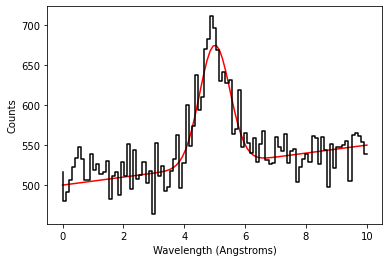

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,1)
ax.plot(wave, flux, 'r-')
ax.step(wave, obs_flux, color='k')
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Counts')

## 2 The pymc3.Model Context

`pymc3` uses a python construct called a *context*. A context is a way to allocate (and de-allocate) resources in specific instances. There's a lot of setup that needs to be done to run MCMC chains and contexts allow the `pymc3` programmers to do all that "behind the scenes" and avoid complicating the user experience. To see a simple example of a context in action, consider the simple task of opening a file, writing something to it, and then closing the file:

In [3]:
fout = open('Output.txt', 'w')
fout.write('Sample output\n')
fout.close()

Because of the way file input/output works, you must explicitly "close" the file with `fout.close()` to ensure all the data is written to the file. But you never open a file without closing. We can do that same thing treating the open statement as a context. You enter a context using the `with..as` statement and use the usual python indenting to indicate when you exit the context.

In [4]:
with open('Output2.txt', 'w') as fout:
    fout.write('Look Ma, no close()\n')

In this case, there is no need to `close()` the file. The context takes care of this for us. When we leave the block (decrease the indenting), `python` closes the file automatically. While we are in the context block, the file remains open for access. In  `pymc3`, we have to build our model inside a `pymc3.Model` context.

## 3 Writing the pymc3 model

### Random Variables

With ``emcee``, we wrote functions to compute priors and likelihoods. With `pystan`, we wrote things in terms of probability distributions in the `STAN` language. With pymc3, we write python code and create pymc3 objects that represent random variables (RVs) drawn from probability distributions. RVs can represent model parameters of interest, nuisance parameters, or observed data. Every `pymc3` RV you create has to be given a name and any arguments required to compute the probability. For example, if we have a random variable called `x` which is drawn from a normal (i.e., Gaussian) distribution:

In [5]:
import pymc3 as pm
with pm.Model() as model:
    x = pm.Normal('x', mu=10, sigma=5)
    print("Here is a random number for x:",x.random())
print(model.basic_RVs)

Here is a random number for x: 9.763091849592039
[x ~ Normal]


Within the context defined by `model`, we have a random variable called `x` which will have a random value drawn from a normal distribution with mean 10 and standard deviation 5. We can actually sample from this model, which will give us a whole bunch of random draws for `x`. Again, we have to do this within the context of the model.

In [6]:
with model:
    trace = pm.sample(5000, tune=1000)

<ipython-input-6-1a698d399db9>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(5000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 13 seconds.


We asked for a sample of 5000 MCMC interations, throwing out the first 1000 as warm-up (or tuning). We could plot out the trace of `x` with matplotlib, but `pymc3` comes with a nice visualization toolset called `arviz` which can do it for us:

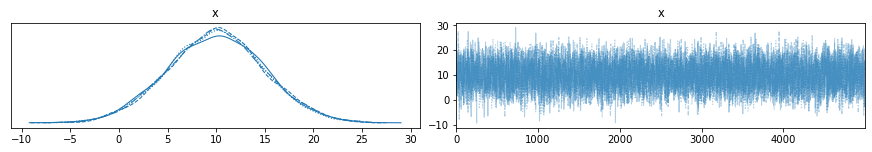

In [7]:
import arviz as az
with model:
    az.plot_trace(trace)

As you can see, the histogram of `x` is precisely what we specified. Though this is a pretty complicated way to draw from a random distribution (we could have just used `np.random.normal`), it illustrates how the modeling works. Now, let's say we have a more realistic situation:  we have a set of data we think are drawn from a normal distribution, but we don't know the mean and standard deviation. Here, we can use `pymc3` to figure it out. First we'll make a set of random data, then fit it.

In [8]:
xobs = random.normal(1.0, 2.0, size=100)   # 100 random values from normal with mean 1 and stddev 2
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=-10, upper=10)    # the unknown mean
    sig = pm.Uniform('sig', lower=0, upper=10)    # the unknown standard deviation
    x = pm.Normal('x', mu=mu, sigma=sig, observed=xobs)  # specify xobs are the obserations of this variable
    trace = pm.sample(5000, tune=1000)
    az.plot_trace(trace)

NameError: name 'random' is not defined

So this shows how we set up two paramters (`mu` and `sig`) that are inferred from data (`xobs`). We can make these models more and more complicated by including more and more "ingredients" to our model using `pymc3`'s various [distributions](https://docs.pymc.io/api/distributions.html).

## 4 Back to the Problem at Hand

Now let's build our inference model for the case of the emission line and background. We'll setup the parameters as before, then tie them together in the model, which we will compare with the observations. We're using the same priors that we used in the previous MCMC notebooks, so refer back to them as a comparison. Note that because `pymc3` RVs are even more complicated than `numpy` arrays, we need to use mathematical functions from `pymc3.math` instead of `numpy`.

In [ ]:
with pm.Model() as model:
    # Our paramters of interest and their priors
    cont = pm.Uniform('cont', lower=-1000, upper=1000)
    slope = pm.Uniform('slope', lower=-100, upper=100)
    amp = pm.Uniform('amplitude', lower=0, upper=1000)
    center = pm.Uniform('center', lower=0, upper=10)
    width = pm.Uniform('width', lower=0, upper=10)
    
    # The model to which we compare the observations
    mod_flux = amp*pm.math.exp(-0.5*(center-wave)**2/width**2) + cont + slope*wave
    flux_obs = pm.Normal('flux_obs', mu=mod_flux, sigma=np.sqrt(flux), observed=flux)
    
    # Get the trace and plot it
    trace = pm.sample(5000, tune=1000)
    az.plot_trace(trace)

And there you go. `pymc3` has a nice compact python-based way of setting up an inference model. Under the hood, it uses the `NUTS` sampler which is well suited for complex and/or high number of dimensions. If you have a new enough version of the `corner` module, it can handle the `pymc3` trace objects as well.

In [ ]:
import corner
with model:
   fig = corner.corner(trace)